In [21]:
import numpy as np 
import torch 
import torchvision
from torchvision import datasets

In [22]:
# load data 
train_data = datasets.FashionMNIST(root='./data', train=True, download=True)

train_x = train_data.data.numpy()
train_y = train_data.targets.numpy()

classes = 10
class_indices = {} # original indices 
polluted_indices = {} # polluted indices 

for i in range(classes):
    indices = np.where(train_y == i)[0] # grab first elem.
    
    np.random.shuffle(indices)
    class_indices[i] = indices 
    polluted_indices[i] = [] # initialize list 

pollution_map = {i: {} for i in range(classes)}

for source_class in range(classes):
    indices = class_indices[source_class]
    total_count = len(indices)
    
    chunk_size = int(total_count * 0.01) # 1% of size 
    leaving_indices = indices[:9 * chunk_size]
    staying_indices = indices[9 * chunk_size:]
    
    # for each class add the staying_indices to their final list 
    polluted_indices[source_class].extend(staying_indices)
    
    # add rest of indices to other classes 
    for k in range(1, 10):
        target_class = (source_class + k) % 10 # determine target class
        
        start = (k -1) * chunk_size 
        end = k * chunk_size
        chunk = leaving_indices[start:end]
        
        polluted_indices[target_class].extend(chunk)
        print(f' class {source_class} polluted class {target_class} with {len(chunk)} images')

# create final arrays 
new_list_x = []
new_list_y = []

for cls in range(classes):
    indices = polluted_indices[cls]
    
    new_list_x.append(train_x[indices]) # get images corresponding images 
    new_list_y.append(np.full(len(indices), cls))
    
polluted_train_x = np.concatenate(new_list_x)
polluted_train_y = np.concatenate(new_list_y)        
        

 class 0 polluted class 1 with 60 images
 class 0 polluted class 2 with 60 images
 class 0 polluted class 3 with 60 images
 class 0 polluted class 4 with 60 images
 class 0 polluted class 5 with 60 images
 class 0 polluted class 6 with 60 images
 class 0 polluted class 7 with 60 images
 class 0 polluted class 8 with 60 images
 class 0 polluted class 9 with 60 images
 class 1 polluted class 2 with 60 images
 class 1 polluted class 3 with 60 images
 class 1 polluted class 4 with 60 images
 class 1 polluted class 5 with 60 images
 class 1 polluted class 6 with 60 images
 class 1 polluted class 7 with 60 images
 class 1 polluted class 8 with 60 images
 class 1 polluted class 9 with 60 images
 class 1 polluted class 0 with 60 images
 class 2 polluted class 3 with 60 images
 class 2 polluted class 4 with 60 images
 class 2 polluted class 5 with 60 images
 class 2 polluted class 6 with 60 images
 class 2 polluted class 7 with 60 images
 class 2 polluted class 8 with 60 images
 class 2 pollute

In [23]:
# check if pollution was successful 
print(f'orginal shape: {train_x.shape}')
print(f'pulluted shape: {polluted_train_x.shape}')

# check counts per class
unique, counts = np.unique(polluted_train_y, return_counts=True)
print('new counts per class: ', dict(zip(unique, counts)))


orginal shape: (60000, 28, 28)
pulluted shape: (60000, 28, 28)
new counts per class:  {np.int64(0): np.int64(6000), np.int64(1): np.int64(6000), np.int64(2): np.int64(6000), np.int64(3): np.int64(6000), np.int64(4): np.int64(6000), np.int64(5): np.int64(6000), np.int64(6): np.int64(6000), np.int64(7): np.int64(6000), np.int64(8): np.int64(6000), np.int64(9): np.int64(6000)}


# Re-train using best model settings

Since I am are no longer using the original FashionMNIST dataset which wraped the data in the transfom passed into it. I now manually perform the operations 

In [24]:
import torchvision.transforms as transforms 
# transform for testset 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalize 
])

In [32]:

tensor_images = torch.from_numpy(polluted_train_x).float() # nueral network uses 
                                                           # floating point math
                                                           # polluted_train_x is a numpy array 

tensor_labels = torch.LongTensor(polluted_train_y) # cross entropy loss uses 
                                                   # Long data type


# print(tensor_images.shape) check shape
# print(tensor_labels.shape)
'''
Need to replicate transform from multi-layer.ipynb manually  
1. add a channel dimension (N, H, W) -> (N, C, H, W)
2. scale values from [0,255] to [0,1]
3. normalize values from transforms.Normalize((0.5), (0.5))

Normalize uses formula: output = (input - mean) / std
''' 

tensor_images = tensor_images.unsqueeze(1) # insert new dimension at index 1 of tensor 
                                           # shape is now (60000, 1, 28, 28)
tensor_images = tensor_images / 255.0 # scale values 

# normalize
tensor_images = (tensor_images - 0.5) / 0.5

polluted_trainset = torch.utils.data.TensorDataset(tensor_images, tensor_labels)
polluted_trainloader = torch.utils.data.DataLoader(polluted_trainset, batch_size=10, 
                                                   shuffle=True, num_workers=2)

# keep test set the same 
testset = torchvision.datasets.FashionMNIST(train=False, root='./data', 
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, 
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


Coat | Sneaker | Sandal | Ankle Boot | T-shirt/top | Shirt | Dress | Trouser | Sneaker | Ankle Boot


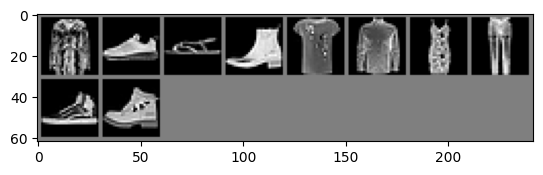

In [26]:
# check dataloader output
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    
dataiter = iter(polluted_trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' | '.join(f'{classes[labels[i]]}' for i in range(len(labels))))

In [27]:
# create model 
import torch.nn as nn
import torch.nn.functional as F

class bestNet(nn.Module):
    def __init__(self):
         super(bestNet, self).__init__()
         
         # Layers
         self.fc1 = nn.Linear(28 * 28, 1024) # 1024 is a hyper parameter
         self.fc2 = nn.Linear(1024, 1024)
         self.fc3 = nn.Linear(1024, 10)
         
         # no convolution 
         
    def forward(self, x):
        # flatten data 
        x = x.view(-1, 28 * 28)
        
                # Run through decision layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
    
net = bestNet()         
    

In [28]:
# loss and back propagation 
import torch.optim as optim 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params= net.parameters() ,lr=0.01, momentum=0)

In [29]:
# train the model
for epoch in range(30):
    running_loss = 0.0
    print_interval = 400
    for i, data in enumerate(polluted_trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % print_interval == print_interval - 1:
            avg_loss = running_loss / print_interval
            print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] loss: {avg_loss:.3f}')
            running_loss = 0.0 
print('finished training')
        

[Epoch 1, Batch   400] loss: 1.492
[Epoch 1, Batch   800] loss: 1.080
[Epoch 1, Batch  1200] loss: 0.995
[Epoch 1, Batch  1600] loss: 0.985
[Epoch 1, Batch  2000] loss: 0.923
[Epoch 1, Batch  2400] loss: 0.952
[Epoch 1, Batch  2800] loss: 0.932
[Epoch 1, Batch  3200] loss: 0.908
[Epoch 1, Batch  3600] loss: 0.894
[Epoch 1, Batch  4000] loss: 0.903
[Epoch 1, Batch  4400] loss: 0.866
[Epoch 1, Batch  4800] loss: 0.898
[Epoch 1, Batch  5200] loss: 0.872
[Epoch 1, Batch  5600] loss: 0.853
[Epoch 1, Batch  6000] loss: 0.859
[Epoch 2, Batch   400] loss: 0.830
[Epoch 2, Batch   800] loss: 0.857
[Epoch 2, Batch  1200] loss: 0.868
[Epoch 2, Batch  1600] loss: 0.842
[Epoch 2, Batch  2000] loss: 0.840
[Epoch 2, Batch  2400] loss: 0.837
[Epoch 2, Batch  2800] loss: 0.804
[Epoch 2, Batch  3200] loss: 0.802
[Epoch 2, Batch  3600] loss: 0.828
[Epoch 2, Batch  4000] loss: 0.834
[Epoch 2, Batch  4400] loss: 0.836
[Epoch 2, Batch  4800] loss: 0.835
[Epoch 2, Batch  5200] loss: 0.818
[Epoch 2, Batch  560

In [30]:
# test the model 
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        
        images, labels = data
        
        # raw model scores
        outputs = net(images)
        # extract highest score
        _, predicted = torch.max(outputs.data, 1)
        # count total images processes so far
        total += labels.size(0)
        # count how many in this batch matches the labels
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total 
print(f'Final accuracy on {total} test images: {accuracy:.1f}%')

Final accuracy on 10000 test images: 88.8%
